### Background info

Followed the 3-year reliability paper: https://doi.org/10.1016/j.neuroimage.2021.118516
1. "Using these source estimates, we then estimated the power of cortical activity in the canonical frequency bands: delta (2–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (15–30 Hz), low gamma (30–80 Hz), and high gamma (80–150 Hz). We used Welch's method for estimating power spectrum densities (PSD) per four-second epoch across each MEG recording, with 1-second sliding Hamming windows overlapping at 50%. We then standardized the PSD values at each frequency bin to the total power across the frequency spectrum. We then averaged PSD maps (ie. source estimates) across epochs for each participant to obtain one set of six PSD maps (one per frequency band) per participant per visit."
2. "We projected these maps onto the MNI ICBM152 brain template (Fonov et al., 2009) and applied a 3 mm FWHM smoothing kernel."
3. "Used single rater two-way mixed-effects model and absolute agreement definition, or ICC(A,1)... ICC estimates and their 95% confidence intervals were calculated using the Matlab Central file-exchange ICC.m function. This ICC calculation was applied at every vertex in the PSD maps to obtain spatially specific reliability estimates at each of the frequency bands. This resulted in an ICC map per frequency band."
4. "To further visualize the reliability of source power in each frequency band, regions of interest (Brainstorm “scouts”) in the frontal, parietal, temporal, and occipital lobes were applied to each participant's PSD map. The average power (relative to total spectral power) across each lobe was extracted for each participant and each visit. ICCs of these values were then calculated using the same ICC(A,1) model."
- "ICC .5 indicates poor reliability, values between .5 to .75 indicates moderate reliability, values between .75 and .9 indicates good reliability, and values greater than .9 indicate excellent reliability. Importantly, we evaluated the level of reliability based on the 95% confidence interval of the ICC estimate, not the estimate itself, since the interval reveals the chance that the true ICC value lands on any point between the bounds."

### Morph

Morph before sprint
- The 3yr reliability paper applied a 3mm smoothing kernel
Sources: 
- https://mne.tools/stable/auto_examples/inverse/morph_surface_stc.html

### ICC

https://github.com/raphaelvallat/pingouin/blob/dcfdc82bbc7f1ba5991b80717a5ca156617443e8/pingouin/reliability.py#L158
ICC2 (single random raters)

### Set up

In [3]:
# IMPORT PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import pickle
import mne
import copy as copy
from pathlib import Path
import csv
import pingouin as pg
import tempfile

# Things to loop through
# dictionary = { 
#     "NVAR008": ["251016", "251017", "251023", "251113"], 
#     "NVAR010": ["251027", "251028", "251103", "251124"], 
#     "NVAR011": ["251030", "251031", "251106", "251127"]
# }
# runs = ["rest1", "rest2"]
# bands = ["delta", "theta", "alpha", "beta", "g_low", "g_high"]

base_dir = "C:/meg/0215_NVAR_sprint_fooof"
#example_stc = mne.read_source_estimate(os.path.join(base_dir, "example_stc"))

# Constants
N_WINDOWS = 115 # 0 to 114
N_VERTICES = 8196

KeyboardInterrupt: 

In [ ]:
# WITHIN-SCAN

# Filenames: Day 1, rest 1
# sub_NVAR999 is a "fake" subject (vertex-shuffled 008)
subject_files = ["sub_NVAR008_251016_rest1", 
                 "sub_NVAR010_251027_rest1", 
                 "sub_NVAR999_251016_rest1"]

# Test
r = 2

# Initialize rows, which will turn into the dataframe that will contain ICC estimates for each vertex
rows = []

# Randomly sample two time windows that are separated by a distance r
for i in range(100): 
    np.random.seed(i)
    windowA = np.random.choice(range(N_WINDOWS - r)) # BASED ON THIS VECTOR YOU BUILD THE OTHER ONE
    windowB = windowA + r

# 100 iterations
for i in range(100): 

    # Loop through all vertices
    for vertex in range(N_VERTICES):
        
        # Since ICC has to be computed separately for each vertex, you need a mini-dataframe for each one
        df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"])

        # For each subject, extract features from time windows
        for subject_file in subject_files: 

            # Extract subject name, for use as factor level
            subject = re.search(r'sub_[A-Z0-9]+', subject_file).group()

            # Load file for this vertex
            file = pd.read_csv(os.path.join(base_dir, "output", subject_file + "fooof_vertex" + str(vertex) + ".csv"))

            # Extract features from windows A and B - call these valA and valB
            valA = file.loc[windowA, "exponent"]
            valB = file.loc[windowB, "exponent"]

            # Add the pair of values to the dataframe
            df_vertex.loc[len(df_vertex)] = [subject, "valA", valA]
            df_vertex.loc[len(df_vertex)] = [subject, "valB", valB]

        # At this point, df_vertex has two vectors - one containing each valA per subject, and one of each valB
        # Compute ICC(A, 1) (single-rater) (ICC2)
        results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
        icc2 = results.loc[results['Type'] == 'ICC2', 'ICC'].values[0]

        # Add ICC for this vertex to the total output
        rows.append([vertex, icc2])

# Convert to dataframe
# There will be 100 ICC estimates for each vertex, meaning that the output will have length N_VERTICES*100
df = pd.DataFrame(rows, columns=["VERTEX", "ICC"])

# Add new column with Fisher transform
df["ICC_Z"] = np.arctanh(df["ICC"]) 
# AVERAGE PER VERTEX
# PLOT WITHOUT THRESH

# Save
with open(os.path.join(base_dir, "ICC_" + str(r) + ".pkl"), "wb") as f: 
    pickle.dump(df, f)

# NEXT STEPS: ADAPT TO DIFFERENT R VALUES
# R VALUES AND FEATURE SHOULD BE INPUTS TO FUNCTION 
# NEXT STEP AFTER THAT: MODEL COMPARISON - FIT LINEAR MODEL ACROSS TIMESCALES - DO THEY FOLLOW A LINEAR TREND - 
# FIT PROGRESSIVELY MORE COMPLICATED MODELS ACROSS TIMESCALE - AIC OR BIC - LINEAR FITS IN SOME BRAIN REGIONS AND NONLINEAR IN OTHERS
# POSTER: SHORTEST POSSIBLE TIMESCALE, DAY, WEEK, MONTH


C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Pyt

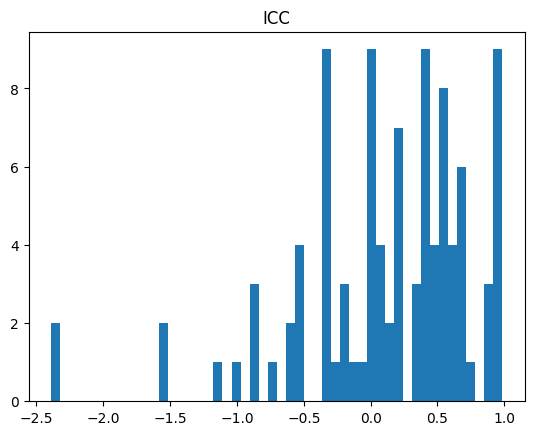

In [24]:
# VISUALIZE OUTPUTS
r = 2
with open(os.path.join(base_dir, "ICC_" + str(r) + ".pkl"), "rb") as f: 
    df = pickle.load(f)

# Make histogram of ICCs for a sample of vertices - expecting a skewed distribution
vertex_data = df[df["VERTEX"] == 0]["ICC"]
plt.hist(vertex_data, bins=50)
plt.title("ICC")
plt.show()

In [17]:
# BETWEEN-SCANS: 

# Filenames: To start, always use visit_1_scan_1 as the reference
comparison_dictionary = {
    "40min" : {
        "sub_NVAR008" : ["sub_NVAR008_251016_rest1_fooof_vertex", "sub_NVAR008_251016_rest2_fooof_vertex"], 
        "sub_NVAR010" : ["sub_NVAR010_251027_rest1_fooof_vertex", "sub_NVAR010_251027_rest2_fooof_vertex"], 
        "sub_NVAR999" : ["sub_NVAR999_251016_rest1_fooof_vertex", "sub_NVAR999_251016_rest2_fooof_vertex"]
    },
    "day" : {
        "sub_NVAR008" : ["sub_NVAR008_251016_rest1_fooof_vertex", "sub_NVAR008_251017_rest1_fooof_vertex"], 
        "sub_NVAR010" : ["sub_NVAR010_251027_rest1_fooof_vertex", "sub_NVAR010_251028_rest1_fooof_vertex"], 
        "sub_NVAR999" : ["sub_NVAR999_251016_rest1_fooof_vertex", "sub_NVAR999_251017_rest1_fooof_vertex"]
    },
    "week" : {
        "sub_NVAR008" : ["sub_NVAR008_251016_rest1_fooof_vertex", "sub_NVAR008_251023_rest1_fooof_vertex"], 
        "sub_NVAR010" : ["sub_NVAR010_251027_rest1_fooof_vertex", "sub_NVAR010_251103_rest1_fooof_vertex"], 
        "sub_NVAR999" : ["sub_NVAR999_251016_rest1_fooof_vertex", "sub_NVAR999_251023_rest1_fooof_vertex"]
    },
    "month" : {
        "sub_NVAR008" : ["sub_NVAR008_251016_rest1_fooof_vertex", "sub_NVAR008_251113_rest1_fooof_vertex"], 
        "sub_NVAR010" : ["sub_NVAR010_251027_rest1_fooof_vertex", "sub_NVAR010_251124_rest1_fooof_vertex"], 
        "sub_NVAR999" : ["sub_NVAR999_251016_rest1_fooof_vertex", "sub_NVAR999_251113_rest1_fooof_vertex"]
    }
}

# Test with sparse r-values
r = 0 # Just the same window in both scans

scale = "40min"

# Initialize rows, which will turn into the dataframe that will contain ICC estimates for each vertex
rows = []

# 100 iterations
for i in range(100): 

    # Randomly sample two time windows that are separated by a distance r
    np.random.seed(i)
    windowA = np.random.choice(range(N_WINDOWS - r))
    windowB = windowA + r

    # Loop through all vertices
    for vertex in range(N_VERTICES):
        
        # Since ICC has to be computed separately for each vertex, you need a mini-dataframe for each one
        df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"])

        # For each subject, extract features from time windows
        for subject in comparison_dictionary[scale]: 

            # Load files for this vertex
            fileA = pd.read_csv(os.path.join(base_dir, "output", comparison_dictionary[scale][subject][0] + str(vertex) + ".csv"))
            fileB = pd.read_csv(os.path.join(base_dir, "output", comparison_dictionary[scale][subject][1] + str(vertex) + ".csv"))

            # Extract features from windows A and B - call these valA and valB
            valA = fileA.loc[windowA, "exponent"]
            valB = fileB.loc[windowB, "exponent"]

            # Add the pair of values to the dataframe
            df_vertex.loc[len(df_vertex)] = [subject, "valA", valA]
            df_vertex.loc[len(df_vertex)] = [subject, "valB", valB]

        # At this point, df_vertex has two vectors - one containing each valA per subject, and one of each valB
        # Compute ICC(A, 1) (single-rater) (ICC2)
        results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
        icc2 = results.loc[results['Type'] == 'ICC2', 'ICC'].values[0]

        # Add ICC for this vertex to the total output
        rows.append([vertex, icc2])

# Save the entire thing
# There will be 100 ICC estimates for each vertex, meaning that the output will have length N_VERTICES*100
df = pd.DataFrame(rows, columns=["VERTEX", "ICC"])
# Later, need to Fisher transform per vertex
with open(os.path.join(base_dir, "ICC_" + scale + str(r) + ".pkl"), "wb") as f: 
    pickle.dump(df, f)

C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)
C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Pyt

KeyboardInterrupt: 

In [25]:
rows

[[0, np.float64(0.059894368085170215)],
 [1, np.float64(-0.19776359111905437)],
 [2, np.float64(-0.7015778311229449)],
 [3, np.float64(0.25179008341674725)],
 [4, np.float64(0.6655380694845356)],
 [5, np.float64(-0.1701490691084921)],
 [6, np.float64(-1.5207501107916215)],
 [7, np.float64(-0.5271404938883668)],
 [8, np.float64(-0.0942479635291968)],
 [9, np.float64(-0.1871246408109921)],
 [10, np.float64(0.13980407114539528)],
 [11, np.float64(-0.7171514702196582)],
 [12, np.float64(0.2943058630794429)],
 [13, np.float64(0.001998046559798823)],
 [14, np.float64(0.5949290045587982)],
 [15, np.float64(0.16436670846555357)],
 [16, np.float64(0.08981513564534595)],
 [17, np.float64(0.9460572640423619)],
 [18, np.float64(-0.37572733991913826)],
 [19, np.float64(-0.30542238433576807)],
 [20, np.float64(-0.24078831194822783)],
 [21, np.float64(0.4813940266525207)],
 [22, np.float64(0.02254016144825603)],
 [23, np.float64(-0.14027117115006832)],
 [24, np.float64(0.4283431861172457)],
 [25, np.

2580
sub_NVAR999
A: window: 37 - value: 1.0858295255601955
B: window: 39 - value: 1.0161349831673667


In [ ]:
# BETWEEN-RUN

# Filenames
subject1_file = "sub_NVAR008_251016_rest1_fooof_window"
subject2_file = "sub_NVAR010_251027_rest1_fooof_window"

r = 2

for i in range(100): 

    # Get indices of valA and valB
    np.random.seed(i)
    windowA = np.random.choice(range(N_WINDOWS - r + 1))
    windowB = windowA + r

    # The dataframe will have the ICC (and CI) at each vertex
    df = pd.DataFrame(columns=["VERTEX", "ICC2", "CI"])

    # Loop through vertices
    for vertex in range(N_VERTICES):
        
        # Since ICC has to be computed separately for each vertex, you need a dataframe for each vertex
        df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"])

        # For each participant, for each vertex, extract valA and valB
        for subject_file in [subject1_file, subject2_file]: 

            # Extract subject name
            subject = re.search(r'sub_[A-Z0-9]+', subject_file).group()

            # Load file
            valA_file = pd.read_csv(os.path.join(base_dir, "output", subject_file + str(windowA) + ".csv"))
            valB_file = pd.read_csv(os.path.join(base_dir, "output", subject_file + str(windowB) + ".csv"))

            # Extract values
            valA = valA_file.loc[vertex, "exponent"]
            valB = valB_file.loc[vertex, "exponent"]

            print(vertex)
            print(subject)
            print("valA " + str(valA))
            print("valB " + str(valB))

            # Add the pair of values
            df_vertex.loc[len(df_vertex)] = [subject, "valA", valA]
            df_vertex.loc[len(df_vertex)] = [subject, "valB", valB]

        # Compute ICC on this vertex
        results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
        icc2 = results.loc[1, 'ICC']
        ci = results.loc[1, "CI95%"]

        # Add to big df
        df.loc[len(df)] = [vertex, icc2, ci]

# Save the entire thing
with open(os.path.join(base_dir, "ICC_" + str(r) + ".pkl"), "wb") as f: 
    pickle.dump(df, f)

# Fisher transform


In [ ]:
subject_file = "sub_NVAR008_251016_rest1_fooof_window"
valA_file = pd.read_csv(os.path.join(base_dir, "output", subject_file + str(windowA) + ".csv"))

In [4]:
base_path = "C:/meg/0215_NVAR_sprint_fooof"
prefix = "sub_NVAR008_251016_rest1"
input_path = os.path.join(base_path, prefix)

print("Path to stc: " + input_path)
stc = mne.read_source_estimate(input_path)
print("stc loaded")

print("Morphing to fsaverage:")
subject = re.search(r'sub_[A-Z0-9]+', prefix).group()
morph = mne.compute_source_morph(
    stc,
    subject_from = subject, 
    subject_to = "fsaverage", # to fsaverage
    subjects_dir = "C:/meg/NVAR_ICC_day/MRI/freesurfer"
    )
stc_morphed = morph.apply(stc)
stc_morphed.save(os.path.join(base_path, prefix + "_morphed"))
print("Morph done")


Path to stc: C:/meg/0215_NVAR_sprint_fooof\sub_NVAR008_251016_rest1
stc loaded
Morphing to fsaverage:
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    7 smooth iterations done.
    10 smooth iterations done.
[done]
[done]


MemoryError: Unable to allocate 18.3 GiB for an array with shape (20484, 120000) and data type float64

In [ ]:
# SPARSE ICC
# Reference point always visit1_scan1

base_filename = "sub_NVAR008_251016_rest1_fooof_window"

r = 2
valA = 0
valB = valA + r

valAfile = pd.read_csv(os.path.join(base_dir, "output", base_filename + str(valA) + ".csv"))
valBfile = pd.read_csv(os.path.join(base_dir, "output", base_filename + str(valB) + ".csv"))

# Loop through vertices
for vertex in range(len(example_stc.vertices)):

    # Since ICC has to be computed separately for each vertex, you need a dataframe for each vertex
    df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"])

    # Get valA for this vertex

                            valA = stc.data[vertex, window]
                        print(valA)
                        valB = stc.data[vertex, window+2]
                        print(valB)

                        # Add the pair of values
                        df_vertex.loc[len(df_vertex)] = ["_".join([subject, session, run]), "valA", valA]
                        df_vertex.loc[len(df_vertex)] = ["_".join([subject, session, run]), "valB", valB]

    # Get valB for this vertex 










# Loop through band, subject, scan, and run
for band in bands: 

    # Create a dataframe just for this band
    # The dataframe will have the ICC (and CI) at each vertex
    df = pd.DataFrame(columns=["VERTEX", "ICC2", "CI"])

    for vertex in range(len(stc.vertices)):

        # Create a dataframe just for this vertex
        df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"]) # subject_scan_run, valA/B, power
        # why is target subject_scan_run? because otherwise there'd be too much variability. We are trying to estimate ICC WITHIN a run

        # Loop through all runs for all sessions for all subjects
        for subject in dictionary: 
            for session in dictionary[subject]:
                for run in runs: 

                    # Read data
                    # TODO

                    # Loop through run windows; the run has 55 windows, numbered 0-54
                    for window in range(53): # Need to stop at 52 so that the final valB is = 54
                        print("Value A: " + str(window))
                        print("Value B: " + str(window+2))

                        valA = stc.data[vertex, window]
                        print(valA)
                        valB = stc.data[vertex, window+2]
                        print(valB)

                        # Add the pair of values
                        df_vertex.loc[len(df_vertex)] = ["_".join([subject, session, run]), "valA", valA]
                        df_vertex.loc[len(df_vertex)] = ["_".join([subject, session, run]), "valB", valB]

        # Compute ICC on this vertex
        results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
        icc2 = results.loc[1, 'ICC']
        ci = results.loc[1, "CI95%"]

    # Add to big df
    df.loc[len(df)] = [vertex, icc2, ci]

    # Save the entire thing
    with open("C:/meg/NVAR_ICC/ICC_inrun_" + band + ".pkl", "wb") as f: 
        pickle.dump(df, f)

Value A: 0
Value B: 2
-0.006775385
-0.0067887795
Value A: 1
Value B: 3
-0.00674534
-0.0052289683
Value A: 2
Value B: 4
-0.0067887795
-0.005200769
Value A: 3
Value B: 5
-0.0052289683
-0.004332451
Value A: 4
Value B: 6
-0.005200769
-0.0027767592
Value A: 5
Value B: 7
-0.004332451
-0.0027784829
Value A: 6
Value B: 8
-0.0027767592
-0.0019104307
Value A: 7
Value B: 9
-0.0027784829
-0.0031747818
Value A: 8
Value B: 10
-0.0019104307
-0.006392469
Value A: 9
Value B: 11
-0.0031747818
-0.0075479527
Value A: 10
Value B: 12
-0.006392469
-0.0066341516
Value A: 11
Value B: 13
-0.0075479527
0.00020857122
Value A: 12
Value B: 14
-0.0066341516
-0.011178154
Value A: 13
Value B: 15
0.00020857122
0.00064289366
Value A: 14
Value B: 16
-0.011178154
0.0024446482
Value A: 15
Value B: 17
0.00064289366
0.002220429
Value A: 16
Value B: 18
0.0024446482
-0.0070072617
Value A: 17
Value B: 19
0.002220429
-0.00013720278
Value A: 18
Value B: 20
-0.0070072617
0.0006007764
Value A: 19
Value B: 21
-0.00013720278
0.000492

AssertionError: Data must have at least 5 non-missing values.

In [ ]:
# ACROSS RUNS: REST1 VS REST2
# Call values from rest1 "valA" and values from rest2 "valB"

# Loop through band, subject, scan, and run
for band in bands: 

    # Create a dataframe just for this band
    # The dataframe will have the ICC (and CI) at each vertex
    df = pd.DataFrame(columns=["VERTEX", "ICC2", "CI"])

    for vertex in range(len(stc.vertices)):

        # Create a dataframe just for this vertex
        df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"]) # subject_scan, valA/B, power
        # why is target subject_scan_run? because otherwise there'd be too much variability. We are trying to estimate ICC within a run 

        # Loop through all runs for all sessions for all subjects
        for subject in dictionary: 
            for session in dictionary[subject]:

                # Loop through run windows; the run has 55 windows, numbered 0-54
                for window in range(55): 

                    # Get file for runA
                    # Read data
                    # TODO
                    stc_rest1 = 
                    valA = stc_rest1.data[vertex, window]

                    # Get file for runB
                    stc_rest2 = 
                    valB = stc_rest2.data[vertex, window]

                    # Add the pair of values
                    df_vertex.loc[len(df_vertex)] = ["_".join([subject, session]), "valA", valA]
                    df_vertex.loc[len(df_vertex)] = ["_".join([subject, session]), "valB", valB]

        # Compute ICC on this vertex
        results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
        icc2 = results.loc[1, 'ICC']
        ci = results.loc[1, "CI95%"]

    # Add to big df
    df.loc[len(df)] = [vertex, icc2, ci]

    # Save the entire thing
    with open("C:/meg/NVAR_ICC/ICC_rest1-vs-rest2_" + band + ".pkl", "wb") as f: 
        pickle.dump(df, f)

In [ ]:
# ACROSS DAYS: TODO!!!!!!!
# Call values from rest1 "valA" and values from rest2 "valB"

# Loop through band, subject, scan, and run
for band in bands: 

    # Create a dataframe just for this band
    # The dataframe will have the ICC (and CI) at each vertex
    df = pd.DataFrame(columns=["VERTEX", "ICC2", "CI"])

    for vertex in range(len(stc.vertices)):

        # Create a dataframe just for this vertex
        df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"]) # subject_scan, valA/B, power
        # why is target subject_scan_run? because otherwise there'd be too much variability. We are trying to estimate ICC within a run 

        # Loop through all runs for all sessions for all subjects
        for subject in dictionary: 


            # 
            for session in dictionary[subject]:

                # Loop through run windows; the run has 55 windows, numbered 0-54
                for window in range(55): 

                    # Get file for runA
                    # Read data
                    # TODO
                    stc_rest1 = 
                    valA = stc_rest1.data[vertex, window]

                    # Get file for runB
                    stc_rest2 = 
                    valB = stc_rest2.data[vertex, window]

                    # Add the pair of values
                    df_vertex.loc[len(df_vertex)] = ["_".join([subject, session]), "valA", valA]
                    df_vertex.loc[len(df_vertex)] = ["_".join([subject, session]), "valB", valB]

        # Compute ICC on this vertex
        results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
        icc2 = results.loc[1, 'ICC']
        ci = results.loc[1, "CI95%"]

    # Add to big df
    df.loc[len(df)] = [vertex, icc2, ci]

    # Save the entire thing
    with open("C:/meg/NVAR_ICC/ICC_rest1-vs-rest2_" + band + ".pkl", "wb") as f: 
        pickle.dump(df, f)

In [ ]:
# DAYS AS RATERS
"""
Shape of stc_average: 
array([[0.0053271 ],
       [0.00452035],
       [0.005533  ],
       ...,
       [0.00313858],
       [0.003465  ],
       [0.00346861]], shape=(20484, 1), dtype=float32)
"""

# Loop through bands
# for band in bands: 
band = "alpha" # test

# Vertex-wise ICC
df = pd.DataFrame(columns=["VERTEX", "ICC2", "CI"])

# Loop through vertices
# There are 20484 vertices
for vertex in range(20484): 

    df_vertex = pd.DataFrame(columns=["TARGET", "RATER", "RATING"]) # subject, session, power

    # Add the value for this vertex for average-morph for each subject/session 
    for subject in dictionary: 
        for session in dictionary[subject]: 
            
            stc_dir = os.path.join(base_dir, "sub_" + subject, session, "beamformer", "stc")
            stc_average_name = os.path.join(stc_dir, "sub_" + subject + "_average_raw_tsss_beamformer_" + band + "_stc_morphed")
            stc = mne.read_source_estimate(stc_average_name)
            power = stc.data[vertex]

            df_vertex.loc[len(df_vertex)] = [subject, session, power[0]]

    # Compute ICC on this
    results = pg.intraclass_corr(data=df_vertex, targets='TARGET', raters='RATER', ratings='RATING')
    icc2 = results.loc[1, 'ICC']
    ci = results.loc[1, "CI95%"]

    # Add to big df
    df.loc[len(df)] = [vertex, icc2, ci]

    # Save the entire thing
    with open("C:/meg/NVAR_ICC/vertexwise_ICC_" + band + ".pkl", "wb") as f: 
        pkl.dump(df, f)

C:\Users\Isabel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pingouin\reliability.py:367: RuntimeWarning: invalid value encountered in scalar divide
  l2 = n * (msb - f2u * mse) / (f2u * (k * msj + (k * n - k - n) * mse) + n * msb)


In [ ]:
# Plot whole-brain ICC maps

def plot_stc_grid(stcs, labels):
    """
    Plot a list of STCs in an nx3 grid (dorsal, right lateral, left lateral).
    
    Parameters
    ----------
    stcs : list of SourceEstimate
        One STC per row.
    labels : list of str
        Row labels. 
    """
    views = ['lateral', 'dorsal', 'lateral']
    hemis = ['rh', 'both', 'lh']

    clim = dict(kind='value', lims=[0, 0.5, 1])
    colormap = 'viridis'

    n = len(stcs)
    fig, axes = plt.subplots(n, 4, figsize=(13, 4 * n),
                         gridspec_kw=dict(width_ratios=[1, 1, 1, 0.05]))

    if n == 1:
        axes = axes[np.newaxis, :]

    for row, stc in enumerate(stcs):
        for col, (view, hemi) in enumerate(zip(views, hemis)):

            brain = stc.plot(
                subject='fsaverage',
                subjects_dir="C:/meg/NVAR_ICC_day/MRI/freesurfer/",
                hemi=hemi,
                views=view,
                clim=clim,
                colormap= colormap, 
                background='white', 
                #surface = "pial", 
                colorbar = False
            )

            img = brain.screenshot()
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            plt.close('all')


        mne.viz.plot_brain_colorbar(axes[row, 3], clim, colormap, label="ICC")

        axes[row, 0].text(-0.1, 0.5, labels[row], transform=axes[row, 0].transAxes,
                  fontsize=20, va='center', ha='right', rotation=0)

    col_titles = ['Right Lateral', 'Dorsal', 'Left Lateral']
    for col, title in enumerate(col_titles):
        axes[0, col].set_title(title, fontsize=20)

    fig.tight_layout()
    return fig

def make_and_plot_stc(files, labels): 
    """
    Given a list of paths to pickle files, makes a list of stcs, then passes them to a function for plotting
    
    Parameters
    ----------
    pkls : list of pkl, each a dataframe with columns: vertex, ICC2, CI
    labels : list of str

    """

    stcs = []

    for file in files: 

        with open(pkl, "rb") as f: 
            df = pickle.load(f)

        stc = mne.SourceEstimate(
            data = df["ICC2"].to_numpy(),
            vertices = [np.arange(0, 10242), np.arange(0, 10242)], 
            tmin=0,
            tstep=1,
            subject="fsaverage"
        )

        stcs.append(stc)
    
    return plot_stc_grid(stcs, labels)


fig = make_and_plot_stc(
    pkls=["C:/meg/NVAR_ICC_day/ICC_alpha.pkl", "C:/meg/NVAR_ICC_day/ICC_beta.pkl", "C:/meg/NVAR_ICC_day/ICC_g_low.pkl"],
    labels=['Alpha', 'Beta', 'Gamma']
)

fig.savefig('C:/meg/NVAR_ICC_day/brain_grid.png', dpi=300, bbox_inches='tight')

False
False
False
False
False
False
False
False
False
